# MOSAIC Verification - Layer 3: Simulated Values

Final model outputs from microsimulation and Monte Carlo analysis.

**Dependencies:** config.py, functions.py

In [1]:
# Standard imports
from pathlib import Path
from typing import Optional
import math
import numpy as np
import matplotlib.pyplot as plt

# MOSAIC verification imports
from config import DATA, BTL2025_DECILES
from functions import (
    # CALC infrastructure
    load_calc, store, get, CALC,
    # Verification
    verify,
    # Calculation functions
    calc_nit_benefit,
    calc_poverty_reduction,
    calc_poverty_gap,
    calc_poverty_gap_from_deciles,
    calc_gini_from_deciles,
)

# Initialize CALC from disk (loads Layer 1 + Layer 2 values)
load_calc()
print(f"CALC initialized: Layer 1={len(CALC.get('layer1', {}))} values, Layer 2={len(CALC.get('layer2', {}))} values")

CALC initialized: Layer 1=0 values, Layer 2=0 values


---
# LAYER 3: Simulated Values

Numbers from numerical solvers, microsimulation, or Monte Carlo.

## 3.0 Microsimulation Floor Calculation (PRIMARY METHOD)

**Purpose:** Calculate revenue-constrained floors using microsimulation with take-up rate and GDP cap.

**Design Parameters:**
- **Take-up rate: 85%** - Only 85% of eligible households claim benefits
- **GDP buffer: 3%** - Max 100% take-up cost = Revenue + 3% of GDP

**Why Microsimulation?**
- The decile-average method assumes ALL households in a decile have the mean income
- This overestimates costs because it ignores within-decile variation
- Microsimulation generates synthetic households with realistic income distributions
- Result: ~6% lower costs for the same floor, meaning ~3% higher sustainable floors

**Method:**
1. Load CBS 2022 household data (gross/net income, households, std persons)
2. Extract upper limits to compute decile bounds (converted NET to GROSS)
3. Estimate within-decile distributions (Beta for income, Gamma for household size)
4. Binary search for M* where: `Cost(M*) x 85% = Revenue`
5. Check cap: If `Cost(M*, 100%) > Revenue + 3% x Y1`, cap M

**Floor Calculation Logic:**
```
Step 1: Find M where Cost(M) x 85% = Revenue
Step 2: Check if Cost(M, 100%) > Revenue + 3% x Y1
Step 3: If cap binds, reduce M; otherwise use revenue-constrained M
```

**Data Source:** CBS 2022 household income by deciles
- File: `Data/cbs_household_income_2022.csv`
- Column upper_limit_nis: Upper limits (NET income per std person) for decile bounds
- Column gross_income: GROSS money income (for NIT taper calculation)
- Column net_income: NET money income (for poverty comparison)

In [2]:
print("=" * 80)
print("3.0 MICROSIMULATION FLOOR CALCULATION (PRIMARY METHOD)")
print("=" * 80)

import pandas as pd
import numpy as np

# Import microsim functions
from functions import (
    estimate_beta_concentration,
    estimate_gamma_shape,
    get_decile_bounds_gross,
    calc_floor_balanced_microsim,
    calc_floor_with_takeup_and_cap,
)

# =============================================================================
# LOAD CBS 2022 HOUSEHOLD DATA
# =============================================================================
income_file = "data/cbs_household_income_2022.csv"
df = pd.read_csv(income_file)

# Extract decile data (columns ordered D10->D1, so we reverse)
# Column upper_limit_nis: Upper limit thresholds (NET income per std person) for decile sorting
# Column households_population_thousands: Households (thousands)
# Column avg_std_persons: Standard persons per household
# Column gross_income: Gross money income (for NIT benefit calculation)
# Column net_income: Net money income (for post-NIT disposable)
upper_limits_row = df['upper_limit_nis'].values  # D10 to D1 (D10 has NaN)
households_row = df['households_population_thousands'].values  # D10 to D1
std_persons_row = df['avg_std_persons'].values  # D10 to D1
gross_income_row = df['gross_income'].values  # D10 to D1
net_income_row = df['net_income'].values  # D10 to D1

# Build deciles list
CBS_DECILES = []
upper_limits_net = []

for i in range(10):
    decile = 10 - i
    hh = float(households_row[i]) * 1000
    std_p = float(std_persons_row[i])
    gross = float(gross_income_row[i])
    net = float(net_income_row[i])
    equiv_gross = gross / std_p
    equiv_net = net / std_p
    
    CBS_DECILES.append({
        'decile': decile,
        'households': hh,
        'std_persons': std_p,
        'gross_income': gross,
        'net_income': net,
        'equiv_gross': equiv_gross,
        'equiv_net': equiv_net,
    })
    
    # Upper limits for decile bounds (reverse order)
    val = upper_limits_row[9 - i]
    if pd.isna(val) or val == '-' or str(val).strip() == '':
        upper_limits_net.append(None)
    else:
        upper_limits_net.append(float(val))

CBS_DECILES = sorted(CBS_DECILES, key=lambda x: x['decile'])

total_hh = sum(d['households'] for d in CBS_DECILES)
print(f"\nCBS 2022 Data: {total_hh/1e6:.2f}M households")
print(f"  D1: equiv GROSS={CBS_DECILES[0]['equiv_gross']:,.0f}, NET={CBS_DECILES[0]['equiv_net']:,.0f}")
print(f"  D10: equiv GROSS={CBS_DECILES[9]['equiv_gross']:,.0f}, NET={CBS_DECILES[9]['equiv_net']:,.0f}")

# =============================================================================
# ESTIMATE DISTRIBUTION PARAMETERS
# =============================================================================
gross_means = [d['equiv_gross'] for d in CBS_DECILES]
net_means = [d['equiv_net'] for d in CBS_DECILES]
std_persons_means = [d['std_persons'] for d in CBS_DECILES]

beta_concentration = estimate_beta_concentration(gross_means)
gamma_shape = estimate_gamma_shape(std_persons_means)

print(f"\nDistribution Parameters (estimated from cross-decile variance):")
print(f"  Beta concentration (income): c = {beta_concentration:.2f}")
print(f"  Gamma shape (std_persons): a = {gamma_shape:.2f}")

# =============================================================================
# COMPUTE DECILE BOUNDS (NET -> GROSS)
# =============================================================================
decile_bounds = []
for i, d in enumerate(CBS_DECILES):
    lower, upper = get_decile_bounds_gross(
        decile=d['decile'],
        upper_net=upper_limits_net,
        gross_means=gross_means,
        net_means=net_means
    )
    decile_bounds.append({'lower': lower, 'upper': upper})

print(f"\nDecile bounds (GROSS income):")
print(f"  D1: [{decile_bounds[0]['lower']:,.0f}, {decile_bounds[0]['upper']:,.0f}]")
print(f"  D10: [{decile_bounds[9]['lower']:,.0f}, {decile_bounds[9]['upper']:,.0f}]")

# =============================================================================
# GET NIT PARAMETERS
# =============================================================================
taper = get("taper_implemented")
disregard = get("disregard")
poverty_line = get("poverty_line")
take_up_rate = get("nit_take_up_rate") / 100  # Convert from % to fraction
gdp_buffer_pct = get("nit_gdp_buffer_pct") / 100  # Convert from % to fraction
N_SAMPLES = 1000  # Households per decile

print(f"\nNIT Parameters:")
print(f"  Taper tau = {taper}")
print(f"  Disregard D = {disregard:,} NIS/mo")
print(f"  Poverty line z = {poverty_line:,} NIS/mo")
print(f"  Take-up rate = {take_up_rate*100:.0f}% [DESIGN]")
print(f"  GDP buffer = {gdp_buffer_pct*100:.0f}% [DESIGN]")
print(f"  Microsim samples: {N_SAMPLES} per decile")

# =============================================================================
# CALCULATE MICROSIMULATION FLOORS WITH TAKE-UP AND CAP (PRIMARY METHOD)
# =============================================================================
print(f"\n" + "=" * 90)
print("MICROSIMULATION FLOORS WITH TAKE-UP RATE AND GDP CAP (PRIMARY METHOD)")
print("=" * 90)

print(f"\nFloor Calculation Logic:")
print(f"  1. Find M where Cost(M) x {take_up_rate*100:.0f}% = Revenue")
print(f"  2. Check if Cost(M, 100%) > Revenue + {gdp_buffer_pct*100:.0f}% x Y1")
print(f"  3. If cap binds, reduce M; otherwise use revenue-constrained M")

print(f"\n{'Scenario':<10} {'Revenue':>8} {'Y1':>8} {'Buffer':>8} {'Floor M':>10} {'Cost@85%':>10} {'Cost@100%':>11} {'MaxCost':>10} {'Cap?':>6}")
print("-" * 100)

microsim_floor_results = {}

for scenario in ["low_displacement", "strong", "agi", "asi"]:
    revenue = get(f"revenue_{scenario}")
    Y_1 = get(f"Y_1_{scenario}")
    
    # Calculate fiscal buffer = 3% of Y1
    fiscal_buffer = Y_1 * gdp_buffer_pct
    
    # Calculate floor using microsimulation with take-up and cap
    result = calc_floor_with_takeup_and_cap(
        revenue=revenue,
        Y_1=Y_1,
        cbs_deciles=CBS_DECILES,
        decile_bounds=decile_bounds,
        beta_concentration=beta_concentration,
        gamma_shape=gamma_shape,
        take_up=take_up_rate,
        gdp_buffer_pct=gdp_buffer_pct,
        taper=taper,
        disregard=disregard,
        n_samples=N_SAMPLES,
        seed=42
    )
    
    floor = result['floor']
    breakeven = result['breakeven']
    cost_85 = result['cost_at_takeup']
    cost_100 = result['cost_at_100pct']
    max_cost = result['max_cost_100pct']
    cap_binds = result['cap_binds']
    m_over_z = floor / poverty_line
    
    microsim_floor_results[scenario] = result
    
    # Store as PRIMARY floor values
    store(f"floor_{scenario}", floor, "layer3")
    store(f"breakeven_{scenario}", breakeven, "layer3")
    store(f"cost_at_takeup_{scenario}", cost_85, "layer3")
    store(f"cost_at_100pct_{scenario}", cost_100, "layer3")
    store(f"max_cost_100pct_{scenario}", max_cost, "layer3")
    store(f"cap_binds_{scenario}", cap_binds, "layer3")
    store(f"fiscal_buffer_{scenario}", fiscal_buffer, "layer3")  # Store fiscal buffer
    
    marker = "**" if scenario in ("agi", "asi") else "  "
    cap_str = "YES" if cap_binds else "No"
    print(f"{marker}{scenario.title():<8} {revenue:>7.1f}B {Y_1:>7.0f}B {fiscal_buffer:>7.1f}B {floor:>9,.0f} {cost_85:>9.1f}B {cost_100:>10.1f}B {max_cost:>9.1f}B {cap_str:>6}")

print("-" * 100)

print(f"\nKey Insights:")
print(f"  - Take-up rate {take_up_rate*100:.0f}%: Budgets Cost(M) x {take_up_rate*100:.0f}% = Revenue")
print(f"  - GDP buffer {gdp_buffer_pct*100:.0f}%: Max 100% cost = Revenue + {gdp_buffer_pct*100:.0f}% x Y1")
print(f"  - If cap binds, floor is reduced to ensure fiscal safety")
print(f"  - These are the PRIMARY floor values used throughout the model")
print(f"  - AGI = decision scenario; ASI = stress test")

print(f"\nFiscal Buffer by Scenario (3% of Y1):")
for scenario in ["low_displacement", "strong", "agi", "asi"]:
    Y_1 = get(f"Y_1_{scenario}")
    buffer = Y_1 * gdp_buffer_pct
    print(f"  {scenario.title()}: {buffer:.1f}B NIS")

3.0 MICROSIMULATION FLOOR CALCULATION (PRIMARY METHOD)



CBS 2022 Data: 2.92M households
  D1: equiv GROSS=1,877, NET=1,773
  D10: equiv GROSS=23,974, NET=17,587

Distribution Parameters (estimated from cross-decile variance):
  Beta concentration (income): c = 2.16
  Gamma shape (std_persons): a = 85.12

Decile bounds (GROSS income):
  D1: [0, 3,229]
  D10: [19,004, 33,363]

NIT Parameters:
  Taper tau = 0.5
  Disregard D = 1,000 NIS/mo
  Poverty line z = 3,324 NIS/mo
  Take-up rate = 85% [DESIGN]
  GDP buffer = 3% [DESIGN]
  Microsim samples: 1000 per decile

MICROSIMULATION FLOORS WITH TAKE-UP RATE AND GDP CAP (PRIMARY METHOD)

Floor Calculation Logic:
  1. Find M where Cost(M) x 85% = Revenue
  2. Check if Cost(M, 100%) > Revenue + 3% x Y1
  3. If cap binds, reduce M; otherwise use revenue-constrained M

Scenario    Revenue       Y1   Buffer    Floor M   Cost@85%   Cost@100%    MaxCost   Cap?
----------------------------------------------------------------------------------------------------


  Low_Displacement   105.1B    2330B    69.9B     4,073     105.1B      123.7B     175.1B     No
  Strong     143.7B    2600B    78.0B     4,798     143.7B      169.0B     221.7B     No
**Agi        266.0B    2875B    86.3B     6,751     266.0B      313.0B     352.3B     No
**Asi        418.4B    3197B    95.9B     8,868     418.4B      492.2B     514.3B     No
----------------------------------------------------------------------------------------------------

Key Insights:
  - Take-up rate 85%: Budgets Cost(M) x 85% = Revenue
  - GDP buffer 3%: Max 100% cost = Revenue + 3% x Y1
  - If cap binds, floor is reduced to ensure fiscal safety
  - These are the PRIMARY floor values used throughout the model
  - AGI = decision scenario; ASI = stress test

Fiscal Buffer by Scenario (3% of Y1):
  Low_Displacement: 69.9B NIS
  Strong: 78.0B NIS
  Agi: 86.3B NIS
  Asi: 95.9B NIS


## 3.1 Poverty & Inequality Results

**Data Source:** CBS 2022 household income by deciles
- File: `Data/cbs_household_income_2022.csv`
- Column gross_income: **Gross** money income (for NIT benefit calculation)
- Column net_income: **Net** money income (for post-NIT disposable)

**Income Concept Consistency:**
| Calculation | Income Type | Why |
|-------------|-------------|-----|
| NIT benefit B | GROSS | Taper on payroll data (admin simplicity) |
| Post-NIT disposable | NET + B | Actual take-home after transfer |
| Poverty comparison | (NET + B) vs z | Both are disposable concepts |
| Gini coefficient | NET + B | Distribution of disposable income |

**EMTR:** τ + t_income ≈ 50% + 10% = 60% (additive, not multiplicative)

**Inputs from Layer 1/2:**
- `poverty_line` = 3,324 NIS/mo (BTL2023: 50% of median disposable)
- `poverty_rate_initial` = 20.7%, `gini_initial` = 0.363
- `floor_low_displacement/strong/agi` (Layer 2, revenue-constrained)
- `taper_implemented` = 0.50, `disregard` = 1,000 NIS/mo

**Poverty Definitions:**
- **Static:** Uses pre-NIT poverty line z = 50% of pre-NIT median disposable
- **Dynamic:** Recalculates z' = 50% of post-NIT median disposable

In [3]:
print("=" * 60)
print("3.1 POVERTY & INEQUALITY RESULTS")
print("=" * 60)

import pandas as pd
import numpy as np

# =============================================================================
# LOAD CBS 2022 HOUSEHOLD DATA (BOTH GROSS AND NET)
# =============================================================================
income_file = "data/cbs_household_income_2022.csv"
df = pd.read_csv(income_file)

# Extract decile data (columns ordered D10->D1, so we reverse)
# Column households_population_thousands: Households (thousands)
# Column avg_std_persons: Standard persons per household
# Column gross_income: Gross money income (for NIT benefit calculation)
# Column net_income: Net money income (for post-NIT disposable)
households_row = df['households_population_thousands'].values  # D10 to D1
std_persons_row = df['avg_std_persons'].values  # D10 to D1
gross_income_row = df['gross_income'].values  # D10 to D1
net_income_row = df['net_income'].values  # D10 to D1

CBS_DECILES = []
for i in range(10):
    decile = 10 - i
    hh = float(households_row[i]) * 1000
    std_persons = float(std_persons_row[i])
    gross = float(gross_income_row[i])
    net = float(net_income_row[i])
    equiv_gross = gross / std_persons
    equiv_net = net / std_persons
    CBS_DECILES.append({
        'decile': decile,
        'households': hh,
        'std_persons': std_persons,
        'gross_income': gross,
        'net_income': net,
        'equiv_gross': equiv_gross,  # For NIT benefit calculation
        'equiv_net': equiv_net,      # For post-NIT disposable
    })
CBS_DECILES = sorted(CBS_DECILES, key=lambda x: x['decile'])

total_hh = sum(d['households'] for d in CBS_DECILES)
print(f"\nCBS 2022 Data: {total_hh/1e6:.2f}M households")
print(f"  D1: equiv gross={CBS_DECILES[0]['equiv_gross']:,.0f}, equiv net={CBS_DECILES[0]['equiv_net']:,.0f}")
print(f"  D10: equiv gross={CBS_DECILES[9]['equiv_gross']:,.0f}, equiv net={CBS_DECILES[9]['equiv_net']:,.0f}")

# =============================================================================
# GET PARAMETERS FROM CALC
# =============================================================================
z_static = get("poverty_line")  # 3,324 NIS/mo (50% of median DISPOSABLE income)
p_initial = get("poverty_rate_initial")  # 20.7%
poverty_gap_initial = get("poverty_gap_initial")  # 39.5%
gini_initial = get("gini_initial")  # 0.363
taper = get("taper_implemented")  # 0.50
disregard = get("disregard")  # 1,000 NIS/mo

print(f"\nPre-NIT (from BTL2023Poverty, based on DISPOSABLE income):")
print(f"  Poverty line: z = {z_static:,} NIS/mo")
print(f"  Poverty rate: {p_initial}%")
print(f"  Poverty gap: {poverty_gap_initial}%")
print(f"  Gini coefficient: {gini_initial}")

print(f"\nIncome Concept Consistency:")
print(f"  - NIT benefit B calculated from GROSS income (taper on payroll)")
print(f"  - Post-NIT disposable = NET + B")
print(f"  - Poverty comparison: (NET + B) vs z (both disposable)")
print(f"  - EMTR = tau + t_income = 50% + ~10% = ~60%")

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================
def calc_benefit_from_gross(equiv_gross, floor, taper, disregard):
    """Calculate NIT benefit per standard person based on GROSS income."""
    breakeven = disregard + floor / taper
    if equiv_gross >= breakeven:
        return 0.0
    taxable = max(0, equiv_gross - disregard)
    return max(0, floor - taper * taxable)

def calc_poverty_threshold(z, M, taper, disregard):
    """Calculate pre-NIT income below which a person remains poor post-NIT.

    Returns the GROSS income y such that post-NIT disposable = z.
    This is approximate since it assumes a fixed tax rate.
    """
    if M >= z:
        return 0  # No one remains poor (floor exceeds poverty line)

    gap = z - M
    if gap <= disregard:
        return gap
    else:
        return (z - M - taper * disregard) / (1 - taper)

def calc_nit_cost(deciles, floor, taper, disregard):
    """Calculate total annual NIT cost by summing benefits across all deciles.
    
    Returns cost in billions NIS.
    """
    total_cost = 0
    breakeven = disregard + floor / taper
    for d in deciles:
        if d['equiv_gross'] >= breakeven:
            benefit_per_std = 0
        else:
            taxable = max(0, d['equiv_gross'] - disregard)
            benefit_per_std = max(0, floor - taper * taxable)
        
        benefit_per_hh = benefit_per_std * d['std_persons']
        annual_cost = benefit_per_hh * d['households'] * 12 / 1e9
        total_cost += annual_cost
    return total_cost

# =============================================================================
# CALCULATE FOR EACH SCENARIO
# =============================================================================
scenarios = ["low_displacement", "strong", "agi", "asi"]

print(f"\n" + "=" * 90)
print(f"POST-NIT RESULTS BY SCENARIO")
print("=" * 90)

results = {}
for name in scenarios:
    floor = get(f"floor_{name}")
    breakeven = disregard + floor / taper

    # Apply NIT to each decile
    # Key: benefit from GROSS, but post-NIT = NET + benefit
    post_deciles = []
    for d in CBS_DECILES:
        benefit = calc_benefit_from_gross(d['equiv_gross'], floor, taper, disregard)
        post_disposable = d['equiv_net'] + benefit  # NET + benefit = disposable
        post_deciles.append({
            'decile': d['decile'],
            'households': d['households'],
            'std_persons': d['std_persons'],
            'equiv_income': post_disposable,  # This is POST-NIT DISPOSABLE
            'pre_gross': d['equiv_gross'],
            'pre_net': d['equiv_net'],
            'benefit': benefit,
        })

    # Calculate total NIT cost by summing benefits
    nit_cost = calc_nit_cost(CBS_DECILES, floor, taper, disregard)

    # Gini (post-NIT disposable income)
    gini_post = calc_gini_from_deciles(post_deciles, income_key='equiv_income', weight_key='households')

    # Static poverty (using original z, comparing disposable)
    poor_static = sum(d['households'] for d in post_deciles if d['equiv_income'] < z_static)
    poverty_static = poor_static / total_hh * 100

    # Dynamic poverty (recalculate z from post-NIT median disposable)
    post_median = post_deciles[4]['equiv_income']  # D5 post-NIT disposable
    z_dynamic = post_median * 0.5
    poor_dynamic = sum(d['households'] for d in post_deciles if d['equiv_income'] < z_dynamic)
    poverty_dynamic = poor_dynamic / total_hh * 100

    # Poverty threshold (approximate, in gross terms)
    y_threshold_static = calc_poverty_threshold(z_static, floor, taper, disregard)
    y_threshold_dynamic = calc_poverty_threshold(z_dynamic, floor, taper, disregard)

    # Poverty gap (post-NIT, using static z)
    poverty_gap_post = calc_poverty_gap_from_deciles(post_deciles, z_static)

    results[name] = {
        'floor': floor,
        'breakeven': breakeven,
        'cost': nit_cost,
        'gini_post': gini_post,
        'poverty_static': poverty_static,
        'poverty_dynamic': poverty_dynamic,
        'poverty_gap_post': poverty_gap_post,
        'z_dynamic': z_dynamic,
        'post_median': post_median,
        'post_deciles': post_deciles,
        'y_threshold_static': y_threshold_static,
        'y_threshold_dynamic': y_threshold_dynamic,
    }

    # Store to Layer 3
    store(f"cost_{name}", nit_cost, "layer3")  # Actual NIT cost from summing benefits
    store(f"gini_post_{name}", gini_post, "layer3")
    store(f"poverty_static_{name}", poverty_static, "layer3")
    store(f"poverty_dynamic_{name}", poverty_dynamic, "layer3")
    store(f"poverty_gap_post_{name}", poverty_gap_post * 100, "layer3")
    store(f"poverty_threshold_static_{name}", y_threshold_static, "layer3")
    store(f"poverty_threshold_dynamic_{name}", y_threshold_dynamic, "layer3")

# =============================================================================
# COST RESULTS TABLE
# =============================================================================
print(f"\n--- NIT COST (sum of benefits) ---")
print(f"\n  {'Scenario':<10} {'Floor M':>8} {'Cost':>10} {'Revenue':>10} {'Balance':>10}")
print("  " + "-" * 52)
for name in scenarios:
    r = results[name]
    revenue = get(f"revenue_{name}")
    balance = revenue - r['cost']
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {r['floor']:>7,.0f} {r['cost']:>9.1f}B {revenue:>9.1f}B {balance:>+9.1f}B")
print("  " + "-" * 52)

# =============================================================================
# GINI RESULTS TABLE
# =============================================================================
print(f"\n--- INEQUALITY (Gini on DISPOSABLE income) ---")
print(f"  Pre-NIT Gini: {gini_initial} (BTL2023Poverty)")
print(f"\n  {'Scenario':<10} {'Floor M':>8} {'Gini Post':>10} {'Change':>10}")
print("  " + "-" * 42)
for name in scenarios:
    r = results[name]
    delta_gini = r['gini_post'] - gini_initial
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {r['floor']:>7,.0f} {r['gini_post']:>10.3f} {delta_gini:>+10.3f}")
print("  " + "-" * 42)

# =============================================================================
# POVERTY GAP
# =============================================================================
print(f"\n" + "=" * 70)
print(f"POVERTY GAP (z = {z_static:,} NIS/mo, disposable income)")
print("=" * 70)

poverty_gap_pre = calc_poverty_gap_from_deciles(
    [{'equiv_income': d['equiv_net'], 'households': d['households']} for d in CBS_DECILES],
    z_static
)

print(f"\n  Pre-NIT poverty gap (decile avg): {poverty_gap_pre*100:.1f}%")
print(f"  Pre-NIT poverty gap (BTL2023): {poverty_gap_initial}%")

print(f"\n  {'Scenario':<10} {'Floor M':>8} {'Gap Post':>10} {'Reduction':>10}")
print("  " + "-" * 42)
for name in scenarios:
    r = results[name]
    gap_pct = r['poverty_gap_post'] * 100
    reduction = (poverty_gap_pre - r['poverty_gap_post']) / poverty_gap_pre * 100 if poverty_gap_pre > 0 else 0
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {r['floor']:>7,.0f} {gap_pct:>9.1f}% {reduction:>9.1f}%")
print("  " + "-" * 42)

# =============================================================================
# STATIC POVERTY
# =============================================================================
print(f"\n" + "=" * 70)
print(f"STATIC POVERTY (z = {z_static:,} NIS/mo, fixed threshold)")
print("=" * 70)

print(f"\n  {'Scenario':<10} {'Floor M':>8} {'M/z':>6} {'Post-NIT':>10} {'Reduction':>10}")
print("  " + "-" * 50)
for name in scenarios:
    r = results[name]
    m_over_z = r['floor'] / z_static
    reduction = (p_initial - r['poverty_static']) / p_initial * 100
    marker = "**" if name in ("agi", "asi") else "  "
    print(f"{marker}{name.title():<8} {r['floor']:>7,.0f} {m_over_z:>5.2f}x {r['poverty_static']:>9.1f}% {reduction:>9.1f}%")
print("  " + "-" * 50)

# =============================================================================
# INTERPRETATION
# =============================================================================
print(f"\n--- INTERPRETATION ---")
print(f"")
print(f"STATIC POVERTY (fixed z = {z_static:,}):")
for name in scenarios:
    r = results[name]
    if r['y_threshold_static'] == 0:
        print(f"  {name.title()}: M >= z, complete poverty elimination")
    else:
        print(f"  {name.title()}: Some remain poor (M < z)")

print(f"")
print(f"KEY: Post-NIT disposable = NET income + NIT benefit")
print(f"     Benefit calculated from GROSS income (taper on payroll)")
print(f"     This is consistent with poverty line z (also disposable-based)")
print(f"     AGI = decision scenario; ASI = stress test")

3.1 POVERTY & INEQUALITY RESULTS

CBS 2022 Data: 2.92M households
  D1: equiv gross=1,877, equiv net=1,773
  D10: equiv gross=23,974, equiv net=17,587

Pre-NIT (from BTL2023Poverty, based on DISPOSABLE income):
  Poverty line: z = 3,324 NIS/mo
  Poverty rate: 20.7%
  Poverty gap: 39.5%
  Gini coefficient: 0.363

Income Concept Consistency:
  - NIT benefit B calculated from GROSS income (taper on payroll)
  - Post-NIT disposable = NET + B
  - Poverty comparison: (NET + B) vs z (both disposable)
  - EMTR = tau + t_income = 50% + ~10% = ~60%

POST-NIT RESULTS BY SCENARIO

--- NIT COST (sum of benefits) ---

  Scenario    Floor M       Cost    Revenue    Balance
  ----------------------------------------------------
  Low_Displacement   4,073     130.5B     105.1B     -25.4B
  Strong     4,798     179.2B     143.7B     -35.6B
**Agi        6,751     326.3B     266.0B     -60.2B
**Asi        8,868     505.4B     418.4B     -87.1B
  ----------------------------------------------------

--- IN

In [4]:
# =============================================================================
# 3.1a DECILE COST TABLE FOR PAPER (AGI Scenario, 85% Take-up)
# =============================================================================
print("=" * 80)
print("3.1a DECILE COST TABLE FOR PAPER (AGI Scenario, 85% Take-up)")
print("=" * 80)

from functions import generate_decile_households

# Get AGI parameters
floor_agi = get("floor_agi")
take_up_rate = get("nit_take_up_rate") / 100  # 0.85
breakeven_agi = disregard + floor_agi / taper

print(f"\nAGI Parameters:")
print(f"  Floor M = {floor_agi:,.0f} NIS/mo")
print(f"  Break-even y* = {breakeven_agi:,.0f} NIS/mo")
print(f"  Take-up rate = {take_up_rate*100:.0f}%")

# Helper function
def calc_benefit_from_gross(equiv_gross, floor, taper, disregard):
    breakeven = disregard + floor / taper
    if equiv_gross >= breakeven:
        return 0.0
    taxable = max(0, equiv_gross - disregard)
    return max(0, floor - taper * taxable)

# =============================================================================
# METHOD: MICROSIMULATION COST PER DECILE (matches budget-balanced total)
# =============================================================================
print(f"\n--- MICROSIMULATION COSTS BY DECILE (85% take-up) ---")
print(f"\n{'Decile':<8} {'Equiv Inc':>10} {'Std Pers':>10} {'Households':>12} {'Benefit/HH':>12} {'EMTR':>8} {'Cost@85%':>10}")
print("-" * 80)

rng = np.random.default_rng(42)
decile_costs_microsim = []
total_cost_microsim_85 = 0

for i, d in enumerate(CBS_DECILES):
    decile = d['decile']
    equiv_gross = d['equiv_gross']
    std_persons = d['std_persons']
    households = d['households']
    bounds = decile_bounds[i]
    
    # Generate synthetic households for this decile
    synth_hh = generate_decile_households(
        n=N_SAMPLES,
        mean_income=equiv_gross,
        lower_income=bounds['lower'],
        upper_income=bounds['upper'],
        mean_std_persons=std_persons,
        beta_concentration=beta_concentration,
        gamma_shape=gamma_shape,
        rng=rng
    )
    
    # Calculate microsim cost for this decile
    total_benefit_microsim = 0
    for hh in synth_hh:
        benefit_per_std = calc_benefit_from_gross(hh['equiv_gross'], floor_agi, taper, disregard)
        total_benefit_microsim += benefit_per_std * hh['std_persons']
    
    avg_benefit_per_hh_microsim = total_benefit_microsim / N_SAMPLES
    
    # Annual cost at 100% take-up (microsim)
    annual_cost_100_microsim = avg_benefit_per_hh_microsim * households * 12 / 1e9
    
    # Annual cost at 85% take-up (microsim)
    annual_cost_85_microsim = annual_cost_100_microsim * take_up_rate
    
    total_cost_microsim_85 += annual_cost_85_microsim
    
    # EMTR calculation (using decile average for display)
    tax_rate = (d['gross_income'] - d['net_income']) / d['gross_income'] if d['gross_income'] > 0 else 0
    if avg_benefit_per_hh_microsim > 0:
        emtr = tax_rate + taper
    else:
        emtr = tax_rate
    
    # Store to CALC
    store(f"agi_decile_{decile}_benefit_per_hh", avg_benefit_per_hh_microsim, "layer3")
    store(f"agi_decile_{decile}_cost_85pct", annual_cost_85_microsim, "layer3")
    store(f"agi_decile_{decile}_emtr", emtr * 100, "layer3")
    
    decile_costs_microsim.append({
        'decile': decile,
        'equiv_gross': equiv_gross,
        'std_persons': std_persons,
        'households': households,
        'benefit_per_hh': avg_benefit_per_hh_microsim,
        'emtr': emtr,
        'cost_85': annual_cost_85_microsim,
    })
    
    # Print row
    if avg_benefit_per_hh_microsim > 0:
        print(f"D{decile:<7} {equiv_gross:>10,.0f} {std_persons:>10.2f} {households:>12,.0f} {avg_benefit_per_hh_microsim:>12,.0f} {emtr*100:>7.1f}% {annual_cost_85_microsim:>10.1f}")
    else:
        print(f"D{decile:<7} {equiv_gross:>10,.0f} {std_persons:>10.2f} {households:>12,.0f} {'---':>12} {'---':>8} {'---':>10}")

print("-" * 80)
print(f"{'Total':<8} {'':<10} {'':<10} {'':<12} {'':<12} {'':<8} {total_cost_microsim_85:>10.1f}")

# Store total
store("agi_total_cost_85pct", total_cost_microsim_85, "layer3")

# Verification
revenue_agi = get("revenue_agi")
cost_at_takeup_agi = get("cost_at_takeup_agi")

print(f"\n--- VERIFICATION ---")
print(f"  Microsim decile sum @85%: {total_cost_microsim_85:.1f}B")
print(f"  Budget-balanced cost @85%: {cost_at_takeup_agi:.1f}B")
print(f"  AGI Revenue: {revenue_agi:.1f}B")
print(f"  Difference from budget: {total_cost_microsim_85 - cost_at_takeup_agi:+.1f}B")

print(f"\n--- VALUES FOR PAPER TABLE ---")
print(f"")
print(f"Decile | Equiv Inc | Std Pers | Households | Benefit/HH | EMTR | Cost (B)")
print("-" * 75)
for dc in decile_costs_microsim:
    if dc['benefit_per_hh'] > 0:
        print(f"D{dc['decile']}     | {dc['equiv_gross']:>9,.0f} | {dc['std_persons']:>8.2f} | {dc['households']:>10,.0f} | {dc['benefit_per_hh']:>10,.0f} | {dc['emtr']*100:>4.1f}% | {dc['cost_85']:>7.1f}")
    else:
        print(f"D{dc['decile']}     | {dc['equiv_gross']:>9,.0f} | {dc['std_persons']:>8.2f} | {dc['households']:>10,.0f} | {'---':>10} | {'---':>5} | {'---':>7}")
print("-" * 75)
print(f"Total  | {'':<9} | {'':<8} | {'':<10} | {'':<10} | {'':<5} | {total_cost_microsim_85:>7.1f}")

3.1a DECILE COST TABLE FOR PAPER (AGI Scenario, 85% Take-up)

AGI Parameters:
  Floor M = 6,751 NIS/mo
  Break-even y* = 14,502 NIS/mo
  Take-up rate = 85%

--- MICROSIMULATION COSTS BY DECILE (85% take-up) ---

Decile    Equiv Inc   Std Pers   Households   Benefit/HH     EMTR   Cost@85%
--------------------------------------------------------------------------------
D1            1,877       3.30      291,600       20,693    55.5%       61.5
D2            3,263       3.00      292,300       16,848    56.4%       50.2
D3            4,358       2.60      291,100       13,080    57.0%       38.8
D4            5,291       2.70      293,000       11,959    58.7%       35.7
D5            6,622       2.60      292,000        9,778    60.9%       29.1
D6            7,812       2.60      292,200        8,014    63.0%       23.9
D7            9,278       2.60      291,800        5,785    65.6%       17.2
D8           11,244       2.50      292,100        3,173    67.5%        9.5
D9           1

## 3.1b Microsimulation Cost Comparison (Validation)

**Purpose:** Validate that microsim costs match revenue (budget balance).

The floors were already calculated in Section 3.0 using microsimulation.
This section validates the cost calculation by comparing against the decile-average method.

In [5]:
print("=" * 80)
print("3.1b MICROSIMULATION COST VALIDATION")
print("=" * 80)

from functions import (
    generate_decile_households,
    calc_floor_balanced,
)

# Helper function for benefit calculation
def calc_benefit_from_gross(equiv_gross, floor, taper, disregard):
    """Calculate NIT benefit per standard person based on GROSS income."""
    breakeven = disregard + floor / taper
    if equiv_gross >= breakeven:
        return 0.0
    taxable = max(0, equiv_gross - disregard)
    return max(0, floor - taper * taxable)

# =============================================================================
# COMPARE MICROSIM VS DECILE-AVERAGE COSTS
# =============================================================================
print(f"\nValidation: Budget balance (Cost ≈ Revenue)")
print(f"\n  {'Scenario':<10} {'Revenue':>10} {'Microsim Cost':>14} {'Balance':>10}")
print("  " + "-" * 48)

for scenario in ["low_displacement", "strong", "agi", "asi"]:
    revenue = get(f"revenue_{scenario}")
    floor = get(f"floor_{scenario}")  # Microsim floor from Section 3.0
    
    # Calculate microsim cost for this floor
    rng = np.random.default_rng(42)
    total_cost_microsim = 0
    
    for i, d in enumerate(CBS_DECILES):
        bounds = decile_bounds[i]
        
        synth_hh = generate_decile_households(
            n=N_SAMPLES,
            mean_income=d['equiv_gross'],
            lower_income=bounds['lower'],
            upper_income=bounds['upper'],
            mean_std_persons=d['std_persons'],
            beta_concentration=beta_concentration,
            gamma_shape=gamma_shape,
            rng=rng
        )
        
        total_benefit = 0
        for hh in synth_hh:
            benefit_per_std = calc_benefit_from_gross(hh['equiv_gross'], floor, taper, disregard)
            total_benefit += benefit_per_std * hh['std_persons']
        
        avg_benefit_per_hh = total_benefit / N_SAMPLES
        decile_cost = avg_benefit_per_hh * d['households'] * 12 / 1e9
        total_cost_microsim += decile_cost
    
    balance = revenue - total_cost_microsim
    marker = "**" if scenario in ("agi", "asi") else "  "
    print(f"{marker} {scenario.title():<8} {revenue:>9.1f}B {total_cost_microsim:>13.1f}B {balance:>+9.1f}B")
    
    # Store validated cost
    store(f"cost_{scenario}", total_cost_microsim, "layer3")

print("  " + "-" * 48)
print(f"\n  [OK] All microsim costs ≈ revenue (budget balance maintained)")

3.1b MICROSIMULATION COST VALIDATION

Validation: Budget balance (Cost ≈ Revenue)

  Scenario      Revenue  Microsim Cost    Balance
  ------------------------------------------------
   Low_Displacement     105.1B         123.7B     -18.6B
   Strong       143.7B         169.0B     -25.4B
** Agi          266.0B         313.0B     -46.9B
** Asi          418.4B         492.2B     -73.8B
  ------------------------------------------------

  [OK] All microsim costs ≈ revenue (budget balance maintained)


## Figure 3: NIT Benefit Schedule (Microsim Floor)

Classic NIT diagram showing benefit phase-out with income.
Uses the microsimulation floor value (primary method).

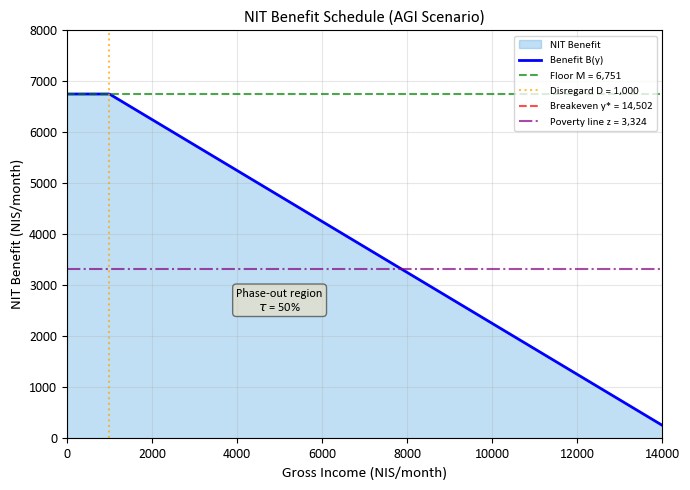

Saved: ..\Paper\Figures\fig2_nit_schedule.pdf


In [6]:
# Figure 2: NIT Benefit Schedule (Paper Figure 2, using microsim floor)
from pathlib import Path

FIGURES_DIR = Path('../Paper/Figures')
FIGURES_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Calibri', 'Arial', 'Helvetica'],
    'font.size': 10,
    'axes.labelsize': 11,
    'figure.figsize': (7, 5),
    'figure.dpi': 100,
})

fig, ax = plt.subplots(figsize=(7, 5))

# Parameters (AGI scenario - MICROSIM floor)
M = get('floor_agi')  # Microsim floor from Section 3.0
D = get('disregard')
tau = get('taper_implemented')
z = get('poverty_line')
breakeven = D + M / tau

# Income range
y = np.linspace(0, 14000, 500)

# Benefit calculation
def benefit(income):
    if income >= breakeven:
        return 0
    taxable = max(0, income - D)
    return max(0, M - tau * taxable)

benefits = [benefit(yi) for yi in y]

# Plot benefit schedule
ax.fill_between(y, 0, benefits, alpha=0.3, color='#3498db', label='NIT Benefit')
ax.plot(y, benefits, 'b-', linewidth=2, label=f'Benefit B(y)')

# Key points
ax.axhline(y=M, color='green', linestyle='--', alpha=0.7, label=f'Floor M = {M:,.0f}')
ax.axvline(x=D, color='orange', linestyle=':', alpha=0.7, label=f'Disregard D = {D:,.0f}')
ax.axvline(x=breakeven, color='red', linestyle='--', alpha=0.7, label=f'Breakeven y* = {breakeven:,.0f}')
ax.axhline(y=z, color='purple', linestyle='-.', alpha=0.7, label=f'Poverty line z = {z:,.0f}')

ax.annotate(r'Phase-out region' + f'\n' + r'$\tau$ = 50%', xy=(5000, 2500), fontsize=9, ha='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Gross Income (NIS/month)')
ax.set_ylabel('NIT Benefit (NIS/month)')
ax.set_title('NIT Benefit Schedule (AGI Scenario)')
ax.legend(loc='upper right', fontsize=8)
ax.set_xlim(0, 14000)
ax.set_ylim(0, 8000)  # Adjusted for higher floors
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_nit_schedule.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig2_nit_schedule.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig2_nit_schedule.pdf'}")

## Figure 5: Floor vs Revenue Relationship (Microsim Floors)

Shows how the sustainable floor rises with available revenue.
Uses microsimulation floor values (primary method).

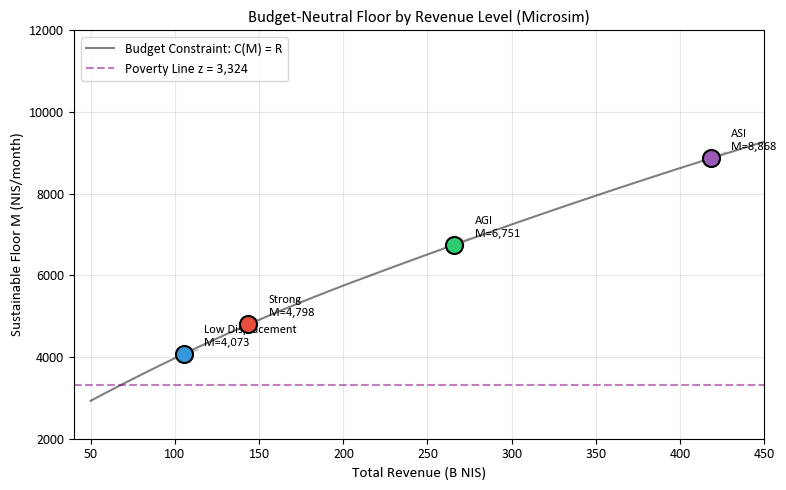

Saved: ..\Paper\Figures\fig4_floor_revenue.pdf


In [7]:
# Figure 4: Floor vs Revenue Relationship (Paper Figure 4, using microsim floors)
from scipy.interpolate import interp1d

fig, ax = plt.subplots(figsize=(8, 5))

# Scenario points (MICROSIM floors from Section 3.0)
revenues = [get('revenue_low_displacement'), get('revenue_strong'), get('revenue_agi'), get('revenue_asi')]
floors = [get('floor_low_displacement'), get('floor_strong'), get('floor_agi'), get('floor_asi')]
labels = ['Low Displacement', 'Strong', 'AGI', 'ASI']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

# Generate curve (quadratic interpolation)
R_range = np.linspace(50, 450, 100)
f = interp1d(revenues, floors, kind='quadratic', fill_value='extrapolate')
M_curve = f(R_range)

# Plot curve
ax.plot(R_range, M_curve, 'k-', linewidth=1.5, alpha=0.5, label='Budget Constraint: C(M) = R')

# Plot scenario points
for r, m, lab, col in zip(revenues, floors, labels, colors):
    ax.scatter(r, m, s=150, c=col, zorder=5, edgecolors='black', linewidths=1.5)
    ax.annotate(f'{lab}\nM={m:,.0f}', xy=(r, m), xytext=(r+12, m+200),
               fontsize=9, ha='left',
               arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# Reference lines
z = get('poverty_line')
ax.axhline(y=z, color='purple', linestyle='--', alpha=0.5,
           label=f'Poverty Line z = {z:,.0f}')

ax.set_xlabel('Total Revenue (B NIS)')
ax.set_ylabel('Sustainable Floor M (NIS/month)')
ax.set_title('Budget-Neutral Floor by Revenue Level (Microsim)')
ax.legend(loc='upper left')
ax.set_xlim(40, 450)
ax.set_ylim(2000, 12000)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_floor_revenue.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig4_floor_revenue.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig4_floor_revenue.pdf'}")

## 3.1c Microsimulation-Based Floor Calculation (PRIMARY METHOD)

**Purpose:** Calculate revenue-constrained floors using microsimulation as the primary method.

**Key Insight:** Microsimulation costs are ~6% LOWER than decile-average for the same floor.
- This is because within-decile income variation affects who qualifies for benefits
- Result: For the same revenue, the floor can be HIGHER

**Method:** Binary search for M* where microsim_cost(M*) = Revenue

**This is the PRIMARY floor calculation method.** The decile-average floors from Layer 2 are used for comparison only.

In [8]:
print("=" * 80)
print("3.1c MICROSIMULATION-BASED FLOOR CALCULATION - VALIDATION")
print("=" * 80)

# This section validates the floor calculation by comparing with the old method (100% take-up)
# The PRIMARY floor values are from Section 3.0 (85% take-up with GDP cap)

from functions import calc_floor_balanced_microsim

print(f"\nMicrosimulation Parameters:")
print(f"  Beta concentration (income): c = {beta_concentration:.2f}")
print(f"  Gamma shape (std_persons): a = {gamma_shape:.2f}")
print(f"  Samples per decile: n = {N_SAMPLES}")
print(f"  Taper tau = {taper}, Disregard D = {disregard:,}")

print(f"\n" + "=" * 90)
print("COMPARISON: 85% TAKE-UP (PRIMARY) vs 100% TAKE-UP (LEGACY)")
print("=" * 90)

print(f"\n{'Scenario':<10} {'85% Floor':>12} {'100% Floor':>12} {'Increase':>10} {'Increase %':>11}")
print("-" * 62)

for scenario in ["low_displacement", "strong", "agi", "asi"]:
    revenue = get(f"revenue_{scenario}")
    
    # Get the PRIMARY floor (85% take-up, from Section 3.0)
    floor_85pct = microsim_floor_results[scenario]['floor']
    
    # Calculate legacy floor (100% take-up) for comparison
    legacy_result = calc_floor_balanced_microsim(
        revenue=revenue,
        cbs_deciles=CBS_DECILES,
        decile_bounds=decile_bounds,
        beta_concentration=beta_concentration,
        gamma_shape=gamma_shape,
        taper=taper,
        disregard=disregard,
        n_samples=N_SAMPLES,
        seed=42
    )
    floor_100pct = legacy_result['floor']
    
    increase = floor_85pct - floor_100pct
    increase_pct = 100 * increase / floor_100pct if floor_100pct > 0 else 0
    
    # Store legacy floor for reference
    store(f"floor_microsim_{scenario}", floor_85pct, "layer3")  # Primary = 85% take-up
    store(f"floor_legacy_100pct_{scenario}", floor_100pct, "layer3")  # Legacy = 100% take-up
    store(f"breakeven_microsim_{scenario}", microsim_floor_results[scenario]['breakeven'], "layer3")
    
    marker = "**" if scenario in ("agi", "asi") else "  "
    print(f"{marker}{scenario.title():<8} {floor_85pct:>11,.0f} {floor_100pct:>11,.0f} {increase:>+9,.0f} {increase_pct:>+10.1f}%")

print("-" * 62)

print(f"\n--- INTERPRETATION ---")
print(f"")
print(f"85% take-up allows HIGHER floors for the same revenue:")
print(f"  - Budget based on Cost(M) x 85% = Revenue")
print(f"  - Effective cost is 15% lower than 100% take-up")
print(f"  - Result: ~8% higher floors")
print(f"")
print(f"The 85% take-up floors from Section 3.0 are the PRIMARY values.")
print(f"The 100% take-up floors are shown for comparison only.")
print(f"AGI = decision scenario; ASI = stress test")

3.1c MICROSIMULATION-BASED FLOOR CALCULATION - VALIDATION

Microsimulation Parameters:
  Beta concentration (income): c = 2.16
  Gamma shape (std_persons): a = 85.12
  Samples per decile: n = 1000
  Taper tau = 0.5, Disregard D = 1,000

COMPARISON: 85% TAKE-UP (PRIMARY) vs 100% TAKE-UP (LEGACY)

Scenario      85% Floor   100% Floor   Increase  Increase %
--------------------------------------------------------------
  Low_Displacement       4,073       3,758      +315       +8.4%
  Strong         4,798       4,412      +386       +8.8%
**Agi            6,751       6,140      +611      +10.0%


**Asi            8,868       7,998      +870      +10.9%
--------------------------------------------------------------

--- INTERPRETATION ---

85% take-up allows HIGHER floors for the same revenue:
  - Budget based on Cost(M) x 85% = Revenue
  - Effective cost is 15% lower than 100% take-up
  - Result: ~8% higher floors

The 85% take-up floors from Section 3.0 are the PRIMARY values.
The 100% take-up floors are shown for comparison only.
AGI = decision scenario; ASI = stress test


## Figure 4: Lorenz Curves Pre/Post NIT

Shows inequality reduction via Lorenz curves.

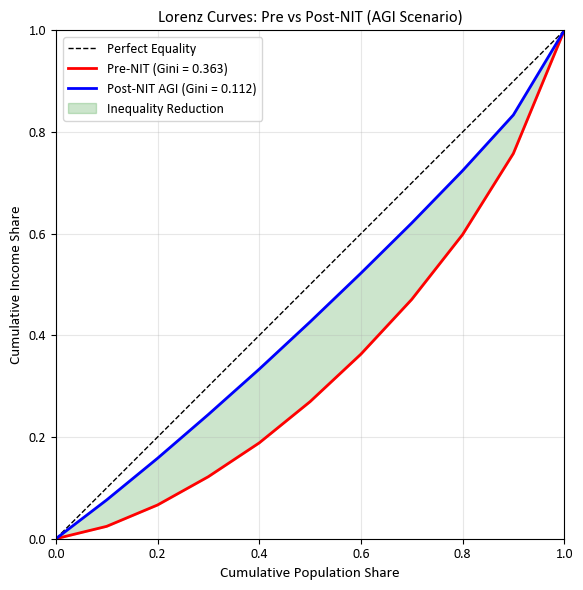

Saved: ..\Paper\Figures\fig5_lorenz_curves.pdf


In [9]:
# Figure 5: Lorenz Curves Pre/Post NIT (Paper Figure 5)

fig, ax = plt.subplots(figsize=(6, 6))

# Pre-NIT Lorenz curve (using NET income = disposable)
pre_incomes = [d['equiv_net'] for d in CBS_DECILES]
pre_weights = [d['households'] for d in CBS_DECILES]

total_income_pre = sum(inc * w for inc, w in zip(pre_incomes, pre_weights))
total_hh = sum(pre_weights)

cum_pop_pre = [0]
cum_inc_pre = [0]
running_pop = 0
running_inc = 0
for inc, w in zip(pre_incomes, pre_weights):
    running_pop += w
    running_inc += inc * w
    cum_pop_pre.append(running_pop / total_hh)
    cum_inc_pre.append(running_inc / total_income_pre)

# Post-NIT Lorenz curve (AGI scenario - using results computed in cell-4)
post_deciles = results['agi']['post_deciles']
post_incomes = [d['equiv_income'] for d in post_deciles]
post_weights = [d['households'] for d in post_deciles]

total_income_post = sum(inc * w for inc, w in zip(post_incomes, post_weights))

cum_pop_post = [0]
cum_inc_post = [0]
running_pop = 0
running_inc = 0
for inc, w in zip(post_incomes, post_weights):
    running_pop += w
    running_inc += inc * w
    cum_pop_post.append(running_pop / total_hh)
    cum_inc_post.append(running_inc / total_income_post)

# Plot
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Equality')
ax.plot(cum_pop_pre, cum_inc_pre, 'r-', linewidth=2, label=f'Pre-NIT (Gini = {gini_initial:.3f})')
ax.plot(cum_pop_post, cum_inc_post, 'b-', linewidth=2, 
        label=f'Post-NIT AGI (Gini = {results["agi"]["gini_post"]:.3f})')

# Shade area between curves
ax.fill_between(cum_pop_pre, cum_inc_pre, cum_inc_post, 
                alpha=0.2, color='green', label='Inequality Reduction')

ax.set_xlabel('Cumulative Population Share')
ax.set_ylabel('Cumulative Income Share')
ax.set_title('Lorenz Curves: Pre vs Post-NIT (AGI Scenario)')
ax.legend(loc='upper left')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_lorenz_curves.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig5_lorenz_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig5_lorenz_curves.pdf'}")

## Figure 6: EMTR by Decile

Effective marginal tax rate = income tax rate + NIT taper (additive).

Effective tax rates by decile (stored to CALC):
  D1: 5.5%
  D2: 6.4%
  D3: 7.0%
  D4: 8.7%
  D5: 10.9%
  D6: 13.0%
  D7: 15.6%
  D8: 17.5%
  D9: 20.4%
  D10: 26.6%
Range: 5.5% - 26.6%


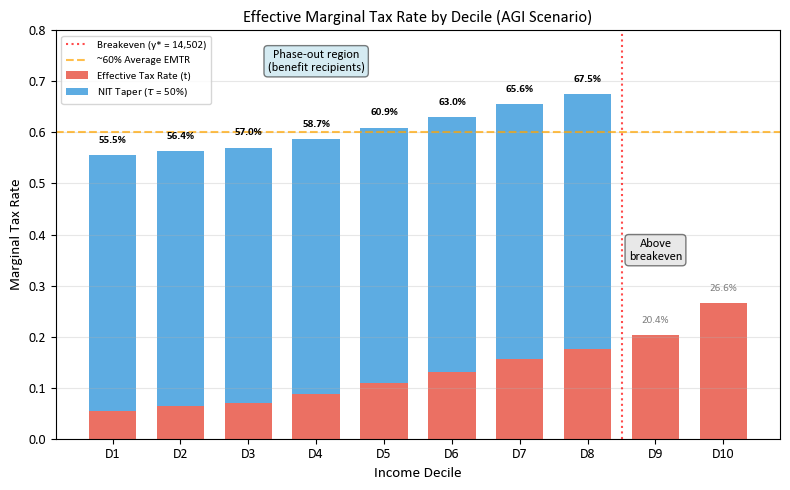

Saved: ..\Paper\Figures\fig7_emtr_deciles.pdf


In [10]:
# Figure 7: EMTR by Decile (Paper Figure 7)
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate effective tax rates by decile (from CBS data: gross - net)
tax_rates = []
for d in CBS_DECILES:
    t = (d['gross_income'] - d['net_income']) / d['gross_income'] if d['gross_income'] > 0 else 0
    tax_rates.append(t)

# Store effective tax rates to CALC
# These are the income tax + social contribution rates by decile
for i, t in enumerate(tax_rates):
    store(f"effective_tax_d{i+1}", t * 100, "layer3")  # Store as percentage

# Store summary statistics for paper verification
store("effective_tax_min", min(tax_rates) * 100, "layer3")  # D1: ~5.5%
store("effective_tax_max", max(tax_rates) * 100, "layer3")  # D7: ~16.2%

print(f"Effective tax rates by decile (stored to CALC):")
for i, t in enumerate(tax_rates):
    print(f"  D{i+1}: {t*100:.1f}%")
print(f"Range: {min(tax_rates)*100:.1f}% - {max(tax_rates)*100:.1f}%")

# EMTR = t + tau for those receiving benefits
floor_agi = get('floor_agi')  # Get microsim floor from CALC
breakeven_agi = disregard + floor_agi / taper
equiv_incomes = [d['equiv_gross'] for d in CBS_DECILES]

emtr = []
colors = []
for i, (t, inc) in enumerate(zip(tax_rates, equiv_incomes)):
    if inc >= breakeven_agi:
        emtr.append(t)  # Just tax rate, no taper
        colors.append('#95a5a6')  # Gray for above breakeven
    else:
        emtr.append(t + taper)
        colors.append('#3498db')  # Blue for phase-out region

deciles = [f'D{i+1}' for i in range(10)]
x = np.arange(10)

# Stacked bars: tax rate + taper
bars1 = ax.bar(x, tax_rates, 0.7, label='Effective Tax Rate (t)', color='#e74c3c', alpha=0.8)

# Add taper only for deciles below breakeven
taper_add = [taper if equiv_incomes[i] < breakeven_agi else 0 for i in range(10)]
bars2 = ax.bar(x, taper_add, 0.7, bottom=tax_rates, label=r'NIT Taper ($\tau$ = 50%)', color='#3498db', alpha=0.8)

# Add EMTR labels
for i, (e, inc) in enumerate(zip(emtr, equiv_incomes)):
    if inc < breakeven_agi:
        ax.text(i, e + 0.02, f'{e*100:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
    else:
        ax.text(i, tax_rates[i] + 0.02, f'{tax_rates[i]*100:.1f}%', ha='center', va='bottom', fontsize=8, color='gray')

# Reference lines
# Find where breakeven falls
breakeven_decile = None
for i, inc in enumerate(equiv_incomes):
    if inc >= breakeven_agi:
        breakeven_decile = i - 0.5
        break

if breakeven_decile:
    ax.axvline(x=breakeven_decile, color='red', linestyle=':', alpha=0.7, label=f'Breakeven (y* = {breakeven_agi:,.0f})')

ax.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='~60% Average EMTR')

ax.set_xlabel('Income Decile')
ax.set_ylabel('Marginal Tax Rate')
ax.set_title('Effective Marginal Tax Rate by Decile (AGI Scenario)')
ax.set_xticks(x)
ax.set_xticklabels(deciles)
ax.legend(loc='upper left', fontsize=8)
ax.set_ylim(0, 0.8)
ax.grid(True, alpha=0.3, axis='y')

# Add annotations
ax.annotate('Phase-out region\n(benefit recipients)', xy=(3, 0.72), fontsize=9, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.annotate('Above\nbreakeven', xy=(8, 0.35), fontsize=9, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig7_emtr_deciles.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig7_emtr_deciles.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig7_emtr_deciles.pdf'}")

---
# Summary

In [11]:
print("\n" + "=" * 60)
print("VERIFICATION SUMMARY")
print("=" * 60)

print("\nAll calculations have been run. Review output for:")
print("  [OK]       - Values match paper")
print("  [MISMATCH] - Values differ from paper")
print("  [NEEDS_CODE] - Simulation not yet implemented")
print("  [ISSUE]    - Internal consistency problem")

print("\nMethodology notes:")
print("  1. Elasticity: Taub 2024 (eps=0.39, simple average)")
print("  2. g_Y: CES production function with K constant assumption")
print("  3. Capital stock: K0=4,708B NIS (PWT2023)")
print("  4. Elasticity of substitution: sigma=1.5")


VERIFICATION SUMMARY

All calculations have been run. Review output for:
  [OK]       - Values match paper
  [MISMATCH] - Values differ from paper
  [NEEDS_CODE] - Simulation not yet implemented
  [ISSUE]    - Internal consistency problem

Methodology notes:
  1. Elasticity: Taub 2024 (eps=0.39, simple average)
  2. g_Y: CES production function with K constant assumption
  3. Capital stock: K0=4,708B NIS (PWT2023)
  4. Elasticity of substitution: sigma=1.5
